In [13]:
%load_ext autoreload

%autoreload 2
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/PySSC/')
import PySSC
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar
import utils
import pandas as pd
import abundance as cl_count
from lnlikelihood import lnLikelihood
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC/SSC_contribution')
import analysis
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

import pyccl as ccl
import edit
import h5py, glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
cat = glob.glob(where_cat)

for i ,c in enumerate(cat):
    cat_test = pd.read_csv(c ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
    ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777
    if i == 20: break
index_analysis = 0
zmin, zmax = analysis.analysisbinned[int(index_analysis)]['zmin'], analysis.analysisbinned[int(index_analysis)]['zmax']
logmmin, logmmax = analysis.analysisbinned[int(index_analysis)]['logmmin'], analysis.analysisbinned[int(index_analysis)]['logmmax']
nzbins, nmbins = 10, 10#analysis.analysisbinned[int(index_analysis)]['nzbins'], analysis.analysisbinned[int(index_analysis)]['nmbins']

clc = cl_count.ClusterAbundance()
clc.sky_area = (0.25)*4*np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(zmin, zmax, 1000)
logm_grid = np.linspace(logmmin, logmmax, 1001)

z_corner = np.linspace(zmin, zmax, nzbins+1)
log10m_corner = np.linspace(logmmin, logmmax, nzbins+1)
Z_bin = [[z_corner[i], z_corner[i+1]] for i in range(len(z_corner)-1)]
print(Z_bin)
LogMass_bin = [[log10m_corner[i], log10m_corner[i+1]] for i in range(len(log10m_corner)-1)]
Nobs, a, b = np.histogram2d(redshift, np.log10(Mvir), bins = [z_corner, log10m_corner])

#choose the halo mass function and mass definition
cosmo = ccl.Cosmology(Omega_c = Omega_c_true + Omega_b_true - 0.048254, Omega_b = 0.048254, 
                          h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
#z_grid = np.linspace(0., 2.1, 2500)
#logm_grid = np.linspace(14.1, 15.7, 2501)

clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = log10m_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')
Halo_bias = NHalo_bias/Abundance
Covariance = covar.Covariance_matrix()
default_cosmo_params = {'omega_b':cosmo['Omega_b']*cosmo['h']**2, 
                                'omega_cdm':cosmo['Omega_c']*cosmo['h']**2, 
                                'H0':cosmo['h']*100, 
                                'n_s':cosmo['n_s'], 
                                'sigma8': cosmo['sigma8'],
                                'output' : 'mPk'}

#kernels
z_arr = np.linspace(0.2,1.2,1000)
nbins_T   = len(Z_bin)
windows_T = np.zeros((nbins_T,len(z_arr)))
for i, z_bin in enumerate(Z_bin):
    Dz = z_bin[1]-z_bin[0]
    z_arr_cut = z_arr[(z_arr > z_bin[0])*(z_arr < z_bin[1])]
    for k, z in enumerate(z_arr):
        if ((z>z_bin[0]) and (z<=z_bin[1])):
            windows_T[i,k] = 1  

Sij_fullsky = PySSC.Sij_alt_fullsky(z_arr, windows_T, order=1, cosmo_params=default_cosmo_params, cosmo_Class=None, convention=0)
Sij_partialsky = Sij_fullsky/clc.f_sky
Sample_covariance = Covariance.sample_covariance_full_sky(Z_bin, LogMass_bin, 
                                                          NHalo_bias, 
                                                          Sij_partialsky)
Cov = Sample_covariance + np.diag(Abundance.flatten())

inv_cov = np.linalg.inv(Cov)

[[0.2, 0.28], [0.28, 0.36], [0.36, 0.44], [0.44, 0.52], [0.52, 0.6000000000000001], [0.6000000000000001, 0.6799999999999999], [0.6799999999999999, 0.76], [0.76, 0.8400000000000001], [0.8400000000000001, 0.9199999999999999], [0.9199999999999999, 1.0]]
top


In [15]:
NNSbb = Covariance.sample_covariance_full_sky(Z_bin, LogMass_bin, 
                                                          NHalo_bias, 
                                                          Sij_partialsky)

top


In [16]:
Sbb = Covariance.sample_covariance_full_sky(Z_bin, LogMass_bin, 
                                                          Halo_bias, 
                                                          Sij_partialsky)

top


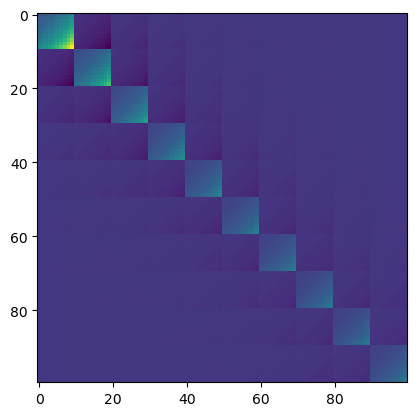

In [17]:
plt.imshow(Sbb)

In [18]:
lnL = lnLikelihood()

In [31]:
Poisson=lnL.lnLikelihood_Binned_Poissonian(Abundance, Nobs,)

In [29]:
Gauss = lnL.lnLikelihood_Binned_Gaussian(Abundance, Nobs, NNSbb,)

In [30]:
Gauss 

-85353.18750572354